In [19]:
using LinearAlgebra: norm
using Random: Random
using Optimization
using OptimizationOptimJL
using ForwardDiff
using LineSearches
using HDF5
using DataFrames
using PyPlot
include("Itdvp_GD.jl")

integrate (generic function with 1 method)

In [20]:
function lossF2T(params::AbstractVector{R}, p::Tuple) where R
    t = 1;
    A = reshape([params[q] + im*params[q+1] for q in 1:2:dH*dBond*dBond*2], (dBond, dH,dBond));
    time_step = p[1]
    h1 = p[2]
    h2 = p[3]
    nT = p[4]

    ALL = nothing
    ACC = nothing
    ARR = nothing
    CC = nothing
    for i in 1:nT
        if ALL == nothing
            AL, AC, AR, C = integrate(h1, A, time_step, t/2)
        else 
            AL, AC, AR, C = integrate(h1, ALL[end], time_step, t/2)
        end
        if ALL == nothing
            ALL = AL[1:end-2]
            ARR = AR[1:end-2]
            ACC = AC[1:end-2]
            CC = C[1:end-2]
        else
            ALL = vcat(ALL, AL[2:end-2])
            ARR = vcat(ARR, AR[2:end-2])
            ACC = vcat(ACC, AC[2:end-2])
            CC = vcat(CC, C[2:end-2])
        end

        AL2, AC2, AR2, C2 = integrate(h2, AL[end], time_step, t/2)
        ALL = vcat(ALL, AL2[1:end-1])
        ARR = vcat(ARR, AR2[1:end-1])
        # println("G")
        ACC = vcat(ACC, AC2[1:end-1])
        # println("G")
        CC = vcat(CC, C2[1:end-1])
    end

    @tensor TC[i,j,k,l] := conj(ALL[end])[i,m,k]*ALL[1][j,m,l]
    res = -log(maximum(abs.(LinearAlgebra.eigvals(reshape(TC, (dBond^2, dBond^2))))))

    return ALL, ACC, ARR, CC, res
end

lossF2T (generic function with 1 method)

In [21]:
function itdvp_obs(al,ac,ar,loc)
    if loc == "x"
        ob = hamiltonian(jx=0., jy=0., jz=0., hx=1., hy=0., hz=0.)
    elseif loc == "y"
        ob = hamiltonian(jx=0., jy=0., jz=0., hx=0., hy=1., hz=0.)
    elseif loc == "z"
        ob = hamiltonian(jx=0., jy=0., jz=0., hx=0., hy=0., hz=1.)
    elseif loc == "xx"
        ob = hamiltonian(jx=1., jy=0., jz=0., hx=0., hy=0., hz=0.)
    elseif loc == "yy"
        ob = hamiltonian(jx=0., jy=1., jz=0., hx=0., hy=0., hz=0.)
    elseif loc == "zz"
        ob = hamiltonian(jx=0., jy=0., jz=1., hx=0., hy=0., hz=0.)
    else
        error("Unknown loc: $loc")
    end

    obsx = []
    for i in 1:length(ar)
        @tensor hc[k,l] := conj(ac[i])[k,i,p] * conj(ar[i])[p,j,q] * ob[i,j,m,n] * ac[i][l,m,o] * ar[i][o,n,q];
        @tensor energy = hc[i,i]
        push!(obsx, energy)
    end
    return obsx
end
function Off_d(al,ac,ar, loc)
    function addTerm(op1, op2)
        @tensor res[i,j,k,l] := op1[i,k]*op2[j,l];
        return res;
    end;
    if loc == "xy"
        ob = addTerm(Sx,Sy)
    elseif loc == "xz"
        ob = addTerm(Sx,Sz)
    elseif loc == "yz"
        ob = addTerm(Sy,Sz)
    end
    obsx = []
    for i in 1:length(ar)
        @tensor hc[k,l] := conj(ac[i])[k,i,p] * conj(ar[i])[p,j,q] * ob[i,j,m,n] * ac[i][l,m,o] * ar[i][o,n,q];
        @tensor energy = hc[i,i]
        push!(obsx, energy)
    end
    return obsx
end;

In [22]:
function ent(c)
    res = Vector{Float64}(undef, length(c)) 
    for i in 1:length(c)
        _, s, _ = svdGauged(c[i])         
        p = s .^ 2
        res[i] = -tr(p .* log.(p))         
    end
    return res
end

ent (generic function with 1 method)

In [23]:
function distance(al)
    n = length(al)
    per = Vector{Float64}(undef, n)
    dim = dBond^2                 # uses global dBond
    for ii in 1:n
        @tensor TC[i,j,k,l] := conj(al[1])[i,m,k] * al[ii][j,m,l]
        per[ii] = abs.(eigsolve(reshape(TC, (dim, dim))))[1][1]
    end

    return per
end


distance (generic function with 1 method)

In [24]:
J = 1.09
dH = 2
h1 = hamiltonian(jx = 0., jy = 0., jz = J, hx = 0., hy = 0., hz = 1.); 
h2 = hamiltonian(jx = 0., jy = 0., jz = 0., hx = J, hy = 0., hz = 0.);
p0 = (0.001, h1, h2, 5)

(0.001, ComplexF64[2.09 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im;;; 0.0 + 0.0im 0.0 + 0.0im; -1.09 + 0.0im 0.0 + 0.0im;;;; 0.0 + 0.0im -1.09 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im;;; 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.09000000000000008 + 0.0im], ComplexF64[0.0 + 0.0im 0.545 + 0.0im; 0.545 + 0.0im 0.0 + 0.0im;;; 0.545 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.545 + 0.0im;;;; 0.545 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.545 + 0.0im;;; 0.0 + 0.0im 0.545 + 0.0im; 0.545 + 0.0im 0.0 + 0.0im], 5)

In [25]:
nice_colors = [
    "mediumorchid",  # Medium violet
    "slateblue",    # Deep violet
    "deepskyblue",   # Light blue
    "dodgerblue",    # Medium blue
    "royalblue",     # Deep blue
    "mediumseagreen", # Greenish-blue
    "seagreen",      # Green
    "yellowgreen",   # Yellow-green
    "gold",         # Yellow
    "darkorange",   # Orange
    "orangered",    # Reddish-orange
    "crimson"       # Red
];

In [26]:
global dBond = 1

1

In [27]:
process_file(file::AbstractString, p0) = begin
    par = h5read(file, "par")
    al, ac, ar, c, res = lossF2T(par, p0)
    ent(c), al[1], res,
    itdvp_obs(al,ac,ar,"x"),
    itdvp_obs(al,ac,ar,"y"),
    itdvp_obs(al,ac,ar,"z")
end

files_by_bond = Dict(
    1 => [
        "./data/281_loss0_J1.09_dB1_dt0.001.h5",
        "./data/121_loss0_J1.09_dB1_dt0.001.h5",
    ],
    2 => [
        "./data/118_res_J109_dB2_dt0.001.h5",
        "./data/67_res_J109_dB2_dt0.001.h5",
        "./data/50_res_J109_dB2_dt0.001_more2.h5",
    ],
    3 => [
        "./data/6_loss0_J109_dB3_dt0.001.h5",
        "./data/52_loss0_J109_dB3_dt0.001.h5",
        "./data/93_loss0_J109_dB3_dt0.001.h5",
        "./data/74_loss0_J109_dB3_dt0.001.h5",
    ],
    4 => [
        "./data/29_loss0_J109_dB4_dt0.001.h5",
        "./data/48_loss0_J109_dB4_dt0.001.h5",
        "./data/25_loss0_J109_dB4_dt0.001.h5",
    ],
)

entang = Dict{Int,Vector{Any}}()
al_vec = Dict{Int,Vector{Any}}()
ress   = Dict{Int,Vector{Any}}()
xo     = Dict{Int,Vector{Any}}()
yo     = Dict{Int,Vector{Any}}()
zo     = Dict{Int,Vector{Any}}()

for db in sort(collect(keys(files_by_bond)))
    global dBond = db
    entang[dBond] = []
    al_vec[dBond] = []      
    ress[dBond]   = []
    xo[dBond]     = Any[]
    yo[dBond]     = Any[]
    zo[dBond]     = Any[]

    for file in files_by_bond[dBond]
        e, a1, r, x, y, z = process_file(file, p0)
        push!(entang[dBond], e)
        push!(al_vec[dBond], a1)
        push!(ress[dBond],   r)
        push!(xo[dBond],     x)
        push!(yo[dBond],     y)
        push!(zo[dBond],     z)
        println(r)
    end
end

xo1, yo1, zo1 = xo[1], yo[1], zo[1]
ress1, entang1, al_vec1 = ress[1], entang[1], al_vec[1]

xo2, yo2, zo2 = xo[2], yo[2], zo[2]
ress2, entang2, al_vec2 = ress[2], entang[2], al_vec[2]

xo3, yo3, zo3 = xo[3], yo[3], zo[3]
ress3, entang3, al_vec3 = ress[3], entang[3], al_vec[3]

xo4, yo4, zo4 = xo[4], yo[4], zo[4]
ress4, entang4, al_vec4 = ress[4], entang[4], al_vec[4]


-2.2204460492503128e-16
-4.440892098500625e-16
1.3269607635012837e-11
1.1598499938265737e-12
6.306987396691953e-9
3.627376177272332e-11
5.9254281127568975e-8
2.5585744637344415e-10
5.728174950788929e-9
8.132547377593432e-8
3.917392909071994e-8
3.138116771367377e-9


(Any[8.132547377593432e-8, 3.917392909071994e-8, 3.138116771367377e-9], Any[[1.3080123986706456, 1.308095715963673, 1.3081789970788558, 1.3082622387155949, 1.3083454375798178, 1.3084285903840887, 1.3085116938477093, 1.3085947446968291, 1.3086777396645464, 1.3087606754910126  …  1.3079478080315932, 1.3079478080315932, 1.3079478080315936, 1.3079478080315936, 1.3079478080315934, 1.3079478080315936, 1.3079478080315936, 1.3079478080315936, 1.3079478080315934, 1.3079478080315938], [1.3830018896227554, 1.3830114308199004, 1.3830209421638127, 1.383030423560244, 1.3830398749152195, 1.3830492961350402, 1.3830586871262813, 1.383068047795796, 1.3830773780507137, 1.3830866777984432  …  1.3829934042498073, 1.3829934042498073, 1.3829934042498078, 1.3829934042498078, 1.3829934042498078, 1.3829934042498073, 1.3829934042498073, 1.3829934042498073, 1.3829934042498073, 1.3829934042498078], [1.2719100016209195, 1.2718715697414391, 1.2718332179863818, 1.2717949471560277, 1.271756758049096, 1.271718651462729

/Users/epetrova/.julia/conda/3/aarch64/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/epetrova/.julia/conda/3/aarch64/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


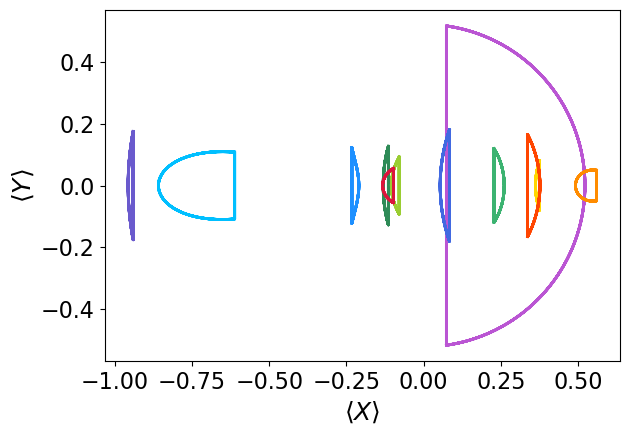

In [28]:
m = 1
all_x = [xo1, xo2, xo3, xo4]
all_y = [yo1, yo2, yo3, yo4]

fig, ax = plt.subplots()

for (X, Y) in zip(all_x, all_y)
    for i in 1:length(X)
        ax.plot(X[i], Y[i], color = nice_colors[m], lw=2)
        m += 1
    end
end

# Labels in LaTeX
ax.set_xlabel(L"$\langle X \rangle$", fontsize=18)
ax.set_ylabel(L"$\langle Y \rangle$", fontsize=18)


# Tick labels same size as axis labels
ax.tick_params(axis="both", which="major", labelsize=16)

# Optional: equal aspect ratio
ax.set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()


In [29]:
entan   = []
al_vec  = []
xo, yo, zo = [], [], []
ppp  = []

dBond = 2
dH = 2

function process_file(fname::String, J::Float64)
    par = h5read(fname, "par")
    h1 = hamiltonian(jx=0., jy=0., jz=J, hx=0., hy=0., hz=1.)
    h2 = hamiltonian(jx=0., jy=0., jz=0., hx=J, hy=0., hz=0.)
    p  = (0.001, h1, h2, 1)

    al, ac, ar, c, res = lossF2T(par, p)
    println(res)

    push!(entan,   ent(c))
    push!(xo,      itdvp_obs(al, ac, ar, "x"))
    push!(yo,      itdvp_obs(al, ac, ar, "y"))
    push!(zo,      itdvp_obs(al, ac, ar, "z"))
    push!(al_vec,  al[1])
    push!(ppp,     par)
end

files = [
    ("./data/118_loss0_J0.6_dB2.h5",      0.6),
    ("./data/118_loss0_J0.7_dB2_dt0.001.h5", 0.7),
    ("./data/100_Jg08.h5",                 0.8),
    ("./data/118_loss0_J0.9_dB2_dt0.001.h5", 0.9),
    ("./data/100_Jg1.h5",                  1.0),
    ("./data/118_loss0_J1.1_dB2_dt0.001.h5", 1.1),
    ("./data/100_Jg12.h5",                 1.2),
    ("./data/118_loss0_J1.3_dB2_dt0.001.h5", 1.3),
    ("./data/100_Jg14.h5",                 1.4),
    ("./data/118_loss0_J1.5_dB2_dt0.001.h5", 1.5),
    ("./data/100_Jg157.h5",                1.5707963),
]

for (fname, J) in files
    process_file(fname, J)
end


-2.2204460492503128e-16
1.534328220032084e-13
1.290141327187034e-10
2.1960211427088007e-13
9.655609645169647e-13
5.887512699588938e-13
6.997680213305968e-11
2.889355421591144e-12
4.419797861033725e-13
9.928534666014355e-10
2.4628310250260338e-8


In [30]:
hex_colormap = ["#00bfff", "#00b5ff", "#00a4ff", "#008eff", "#0077df",
                "#0061bf", "#007d7f", "#00906f", "#00a35f", "#82b64f", "#a9c83f"];


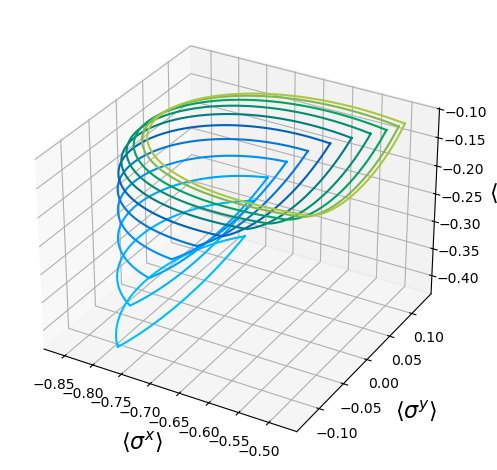

/Users/epetrova/.julia/conda/3/aarch64/lib/python3.10/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


In [31]:
fig = plt.figure()
size_ = 16
ax = fig.add_subplot(111, projection="3d")
m = 1
for i in 1:11
    ax.plot(xo[i], yo[i], zo[i], color= hex_colormap[m])
    ax.set_xlabel(L"$\langle \sigma^x \rangle$", labelpad=6, fontsize=size_)
    ax.xaxis.set_rotate_label(false)
    ax.set_ylabel(L"$\langle \sigma^y \rangle$", labelpad=12, fontsize=size_)
    ax.yaxis.set_rotate_label(false)
    ax.set_zlabel(L"$\langle \sigma^z \rangle$", labelpad=12, fontsize=size_)
    ax.zaxis.set_rotate_label(false)
    m += 1
end
plt.tight_layout()

In [32]:
# Jacobian computation
# In the following, we dont want to accidently change the gauge using mixedCanonical, that is why all functions pass tensors AL, AC, AR and C

In [43]:
delta_ = 0.001 
function Jacc(al___, p)
    basis_1 = Tbasis(al___)
    
    Jac2 = zeros(ComplexF64, 2*dBond^2, 2*dBond^2)
    # delta_ = 0.0001
    
    for i in 1:dBond^2
        al_pert = al___ + delta_*basis_1[i]
        al_pert, ac_pert, ar_pert, c_pert = mixedCanonical(al_pert)[1:4];
        al_pert, ac, ar, c2 = lossF2T_stab1(al_pert, ac_pert, ar_pert, c_pert, p) 
        coefficients  = find_transformation_matrix3(al_pert[end], basis_1, al___)
        for j in 1:dBond^2
            Jac2[j,i] = real(coefficients)[j]
        end
        for j in (dBond^2+1):(2*dBond^2)
            Jac2[j,i] = imag(coefficients)[j-dBond^2]
        end
    end

    for i in (dBond^2+1):(2*dBond^2)
        al_pert = al___ + im*delta_*basis_1[i-dBond^2]

        al_pert, ac_pert, ar_pert, c_pert = mixedCanonical(al_pert)[1:4];
        al_pert, ac, ar, c2= lossF2T_stab1(al_pert, ac_pert, ar_pert, c_pert, p) 
        coefficients  = find_transformation_matrix3(al_pert[end], basis_1, al___)
        for j in 1:dBond^2
            Jac2[j,i] = real(coefficients)[j]
        end
        for j in (dBond^2+1):(2*dBond^2)
            Jac2[j,i] = imag(coefficients)[j-dBond^2]
        end
    end
    return Jac2
end

Jacc (generic function with 1 method)

In [44]:
using LinearAlgebra, Optim

function cost_function(params, A, basis_1, al___)
    # Reconstruct X from the real-valued parameters
    pp = [params[i] + im*params[i+1] for i in 1:dH:2*dBond^2]
    X = sum([basis_1[i]*pp[i] for i in 1:dBond^2]) + al___
    @tensor TT[i,j,k,l] := conj(X)[i,m,k]*X[j,m,l]
    res1 = maximum(abs.(LinearAlgebra.eigvals(reshape(TT, (dBond^2, dBond^2)))))
    X /= sqrt(res1)
    @tensor TT[i,j,k,l] := conj(X)[i,m,k]*A[j,m,l]
    res = maximum(abs.(LinearAlgebra.eigvals(reshape(TT, (dBond^2, dBond^2)))))
    return 1 - res
end

function find_transformation_matrix3(A, basis_1, al___)
    # Initial guess for X (identity matrix with real-valued params)
    initial_guess = zeros(2*dBond^2) 
    

    # Perform optimization to minimize the cost function
    result = optimize(params -> cost_function(params, A, basis_1, al___),
                      initial_guess, BFGS(alphaguess = LineSearches.InitialStatic(), linesearch = LineSearches.HagerZhang()))

    opt_params = result.minimizer

    pp = [opt_params[i] + im*opt_params[i+1] for i in 1:2:2*dBond^2]
    # # Reconstruct the optimized matrix X
    X_opt = sum([basis_1[i]*pp[i] for i in 1:(dBond^2)]) + al___

    @tensor TT[i,j,k,l] := conj(X_opt)[i,m,k]*X_opt[j,m,l]
    res1 = maximum(abs.(LinearAlgebra.eigvals(reshape(TT, (dBond^2, dBond^2)))))
    X_opt /= sqrt(res1)

    X_opt = X_opt - al___ 
    coefficients  = []
    for m in 1:(dBond^2)
        @tensor c1 = conj(basis_1[m])[i,j,k]*X_opt[i,j,k]
        push!(coefficients, c1)
    end
    return coefficients/delta_
end

find_transformation_matrix3 (generic function with 1 method)

In [45]:
Jg = [0.6,0.7, 0.8,0.9, 1., 1.1, 1.2, 1.3, 1.4, 1.5, 1.57];

In [46]:
# Tangent basis construction
function Tbasis(A)
    V = reshape(nullspace(transpose(reshape(conj(A), (dBond*dH,dBond)))), (dBond,dH,dBond))

    basisM = Array{Matrix{Float64}}(undef, dBond^2)
    index = 1
    for i in 1:dBond
        for j in 1:dBond
            M = zeros(dBond, dBond)
            M[i, j] = 1
            basisM[index] = M
            index += 1
        end
    end
    basis_B = Array{Array{ComplexF64,3}}(undef, dBond^2)
    for i in 1:dBond^2
        @tensor B_matrix[j, m, n] := V[j, m, k] *  basisM[i][k, n]
        basis_B[i] = B_matrix
    end
    return basis_B
end

Tbasis (generic function with 1 method)

In [47]:
function lossF2T_stab1(al, ac, ar, c, p::Tuple)
    time_step, h1, h2, nT = p
    half = 0.5
    ALL = []
    ACC = []
    ARR = []
    CC  = []
    cur_al, cur_ac, cur_ar, cur_c = al, ac, ar, c

    for _ in 1:nT
        # First half step with h1
        AL, AC, AR, C = integrate_l1(h1, cur_al, cur_ac, cur_ar, cur_c, time_step, half)
        append!(ALL, AL);  append!(ACC, AC);  append!(ARR, AR);  append!(CC, C)
        cur_al, cur_ac, cur_ar, cur_c = AL[end], AC[end], AR[end], C[end]

        # Second half step with h2
        AL2, AC2, AR2, C2 = integrate_l1(h2, cur_al, cur_ac, cur_ar, cur_c, time_step, half)
        append!(ALL, AL2); append!(ACC, AC2); append!(ARR, AR2); append!(CC, C2)
        cur_al, cur_ac, cur_ar, cur_c = AL2[end], AC2[end], AR2[end], C2[end]
    end

    return ALL, ACC, ARR, CC
end


lossF2T_stab1 (generic function with 1 method)

In [48]:
# Returns only array size 2 t = 0, t = T

function integrate_l1(h, al, ac, ar, c, time_step, t)
    
    l = Int(floor(t /time_step))
    AL = Vector{Array{ComplexF64, 3}}(undef, 2)
    AC = Vector{Array{ComplexF64, 3}}(undef, 2)
    AR = Vector{Array{ComplexF64, 3}}(undef, 2)
    C = Vector{Matrix{ComplexF64}}(undef, 2)
    AL[1], AC[1], AR[1], C[1] = al, ac, ar, c
    AL_, AC_, AR_, C_= al, ac, ar, c
    ti = 0
    for i in 1:Int(l)
        ti += time_step
        AL_ , AC_ , AR_, C_ , _, _, _, _ = eulerStepExp(AL_ , AC_ , AR_ , C_ , h, tstep=time_step);
    end
    t_last = t - l*time_step
    ti+=t_last
    AL[2], AC[2], AR[2], C[2], _, _, _, _ = eulerStepExp(AL_, AC_, AR_, C_, h, tstep = t_last);
    return AL, AC, AR, C
end

integrate_l1 (generic function with 1 method)

In [49]:
J = 0
Ja = []
dBond = 2
lambda = []
for i in 1:11
    J = Jg[i]
    println(J)
    h1 = hamiltonian(jx = 0., jy = 0., jz = J, hx = 0., hy = 0., hz = 1.); 
    h2 = hamiltonian(jx = 0., jy = 0., jz = 0., hx = J, hy = 0., hz = 0.); 
    p = (0.001, h1, h2, 1)
    A = reshape([ppp[i][q] + im*ppp[i][q+1] for q in 1:2:dH*dBond*dBond*2], (dBond, dH,dBond));
    al,ac,ar,c = mixedCanonical(A)
    push!(Ja, Jacc(al, p))
    rr = abs.(LinearAlgebra.eigvals(Ja[i]))
    push!(lambda, log(abs(rr[argmax(rr)])))
end

0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.57


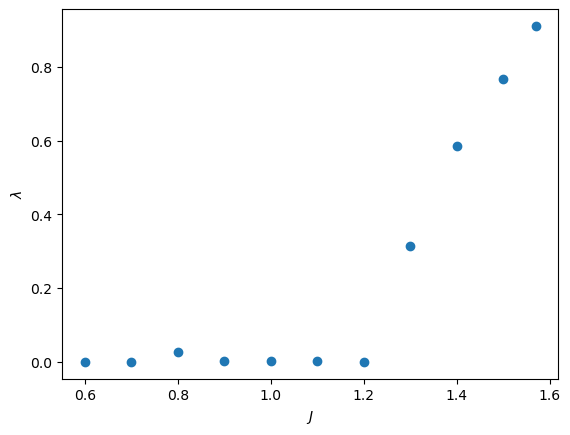

PyObject Text(0.5, 27.0, '$J$')

In [53]:
plt.plot(Jg,lambda,"o")
plt.ylabel(L"$\lambda$")
plt.xlabel(L"J")